In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [3]:
dataset_meta = ['desai_dmso']
dataset_names = dataset_meta 
raw_data_locations = dataset_meta

transcriptome_filepath = './gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


loom_filepaths = ['/home/tchari/counts/loom_desai_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)

In [4]:
loom_filepaths

['/home/tchari/counts/loom_desai_kb/desai_dmso.loom']

In [5]:
n_datasets = len(loom_filepaths)

## **Filtering**

In [6]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

/home/tchari/counts/loom_desai_kb/desai_dmso.loom
Dataset desai_dmso. 
	904 barcodes in loom, 831 pass filter.


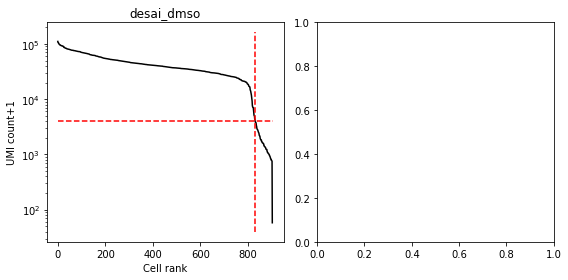

In [7]:
cf = []
thr_lb = [4e3, 4e3]
S_arr = []
U_arr = []


fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = dataset_meta[k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        ax1[k].set_title(dataset_meta[k])        
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter.')

        S_arr.append(S)
        U_arr.append(U)
        cf.append(cf_)
fig1.tight_layout()
plt.savefig('figs/kneeplots_desai.png',dpi=450)


In [8]:
[x.sum() for x in cf]

[831]

## **Preprocessing**

In [9]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)


In [10]:
meta = pd.read_csv('/home/tchari/metadata/Genes_FPKM_more_than2.csv')
meta.head()

,Gene Name,TPM,FPKM
0,Dok1,2.94,2.00
1,Noxred1,2.94,2.00
2,Ccdc102a,2.95,2.00
3,Fchsd1,2.95,2.00
4,Lix1l,2.95,2.01


In [11]:
markers = list(meta['Gene Name'])

In [29]:
#Filter again for acceptable U/S bounds
#Read in loom + layers
filt_param={
        "min_U_mean": 0.01,
        "min_S_mean": 0.01,
        "max_U_max": 400,
        "max_S_max": 400,
        "min_U_max": 1,
        "min_S_max": 1,
    }

ds = lp.connect(loom_filepaths[0])
s = ds.layers['spliced'][:,:]
u = ds.layers['unspliced'][:,:]
g_names = ds.ra['gene_name']
expr_filt = monod.preprocess.threshold_by_expression(s,u,filt_param)
ds.close()

INFO:root:8874 genes retained after expression filter.


In [30]:
fin_markers = set(markers).intersection(list(g_names[expr_filt]))
len(fin_markers)

7854

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230430_026_desai_1 created.
INFO:root:Dataset: desai_dmso
INFO:root:831 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:3836 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230430_026_desai_1/desai_dmso created.
INFO:root:Total of 7854 genes selected.
INFO:root:Directory ./fits/gg_230430_026_desai_1/diagnostic_figures created.


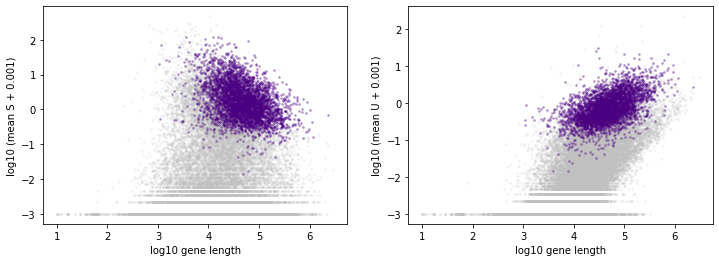

In [31]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='desai',batch_id=1,\
                                             n_genes=7854,exp_filter_threshold=None,cf=cf,genes_to_fit=fin_markers)

## **Inference**

In [12]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-6.55, -1.2]
samp_ub = [-6.55, -1.2]
gridsize = [1,1]


gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1}

INFO:root:Directory ./fits/gg_230430_026_desai_1/desai_dmso/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230430_026_desai_1/desai_dmso/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: desai_dmso
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_230430_026_desai_1/genes.csv.
INFO:root:Directory ./fits/gg_230430_026_desai_1/desai_dmso/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230430_026_desai_1/desai_dmso/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:52<00:00, 232.91s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230430_026_desai_1/desai_dmso/Bursty_Poisson_1x1/analysis_figures created.
INFO:root:Runtime: 233.6 seconds.


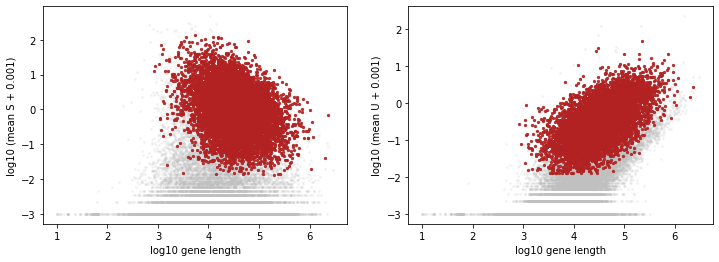

In [33]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(50,search_data)
    result_strings.append(full_result_string)

In [34]:
result_strings

['./fits/gg_230430_026_desai_1/desai_dmso/Bursty_Poisson_1x1/grid_scan_results.res']

In [13]:
result_strings = ['./fits/gg_230430_026_desai_1/desai_dmso/Bursty_Poisson_1x1/grid_scan_results.res']

In [38]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    #fig1,ax1 = plt.subplots(1,1)
#     if i==0:
    sr.find_sampling_optimum()
#     else:
#         sr.set_sampling_optimum(samp_ind)
# #         samp_ind = sr.sampl
#     sr.plot_landscape(ax1)

#     fig1,ax1 = plt.subplots(1,1)
#     sr.plot_KL(ax1)

    #sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    #sr.resample_opt_viz()
    #sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=60)
#     sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
#     sr.plot_param_marg()
    
    samp_ind = sr.samp_optimum_ind
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)

INFO:root:Grid scan results loaded from ./fits/gg_230430_026_desai_1/desai_dmso/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230430_026_desai_1/desai_dmso/raw.sd.
INFO:root:Chi-square computation complete. Rejected 846 genes out of 7854. Runtime: 15.6 seconds.
INFO:root:Original optimum: -6.55, -1.20.
INFO:root:Chi-square computation complete. Rejected 846 genes out of 7854. Runtime: 15.6 seconds.
INFO:root:New optimum: -6.55, -1.20.
INFO:root:Chi-square computation complete. Rejected 846 genes out of 7854. Runtime: 15.6 seconds.
INFO:root:New optimum: -6.55, -1.20.
INFO:root:Chi-square computation complete. Rejected 846 genes out of 7854. Runtime: 15.8 seconds.
INFO:root:New optimum: -6.55, -1.20.
INFO:root:Chi-square computation complete. Rejected 846 genes out of 7854. Runtime: 15.7 seconds.
INFO:root:New optimum: -6.55, -1.20.
INFO:root:Chi-square computation complete. Rejected 846 genes out of 7854. Runtime: 15.7 seconds.
INFO:root:Optimum 

INFO:root:Gene 3109 ran into singularity; replaced with mean. (Search converged to local minimum?) 
INFO:root:Gene 3170 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3193 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3254 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3332 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3412 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3501 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3538 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3560 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3565 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 6400 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6440 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6441 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6465 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6471 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6510 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6522 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6574 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6673 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 6717 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:

In [30]:
sd_test = monod.analysis.load_search_data('./fits/gg_230430_026_desai_1/desai_dmso/raw.sd')

INFO:root:Search data loaded from ./fits/gg_230430_026_desai_1/desai_dmso/raw.sd.


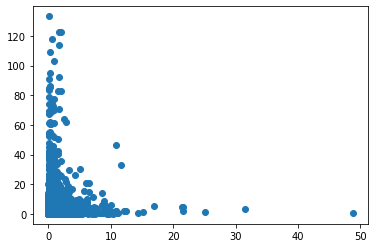

In [31]:
plt.scatter(np.mean(sd_test.layers[0],axis=1),np.mean(sd_test.layers[1],axis=1))

In [41]:
np.corrcoef(np.mean(sd_test.layers[0],axis=1),np.mean(sd_test.layers[1],axis=1))

array([[1.        , 0.02810763],
       [0.02810763, 1.        ]])

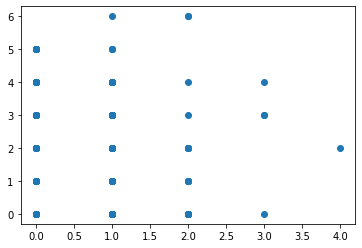

In [32]:
plt.scatter(sd_test.layers[0][10,:],sd_test.layers[1][10,:])

In [34]:
np.corrcoef(sd_test.layers[0][10,:],sd_test.layers[1][10,:])

array([[1.       , 0.1139293],
       [0.1139293, 1.       ]])

In [35]:
sr_test = monod.analysis.load_search_results('./fits/gg_230430_026_desai_1/desai_dmso/Bursty_Poisson_1x1/grid_scan_results.res')

INFO:root:Grid scan results loaded from ./fits/gg_230430_026_desai_1/desai_dmso/Bursty_Poisson_1x1/grid_scan_results.res.


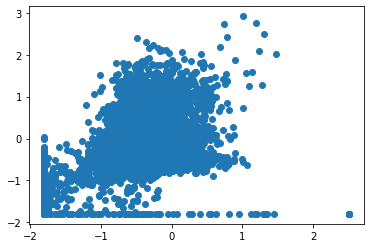

In [37]:
plt.scatter(sr_test.param_estimates[0,:,1],sr_test.param_estimates[0,:,2])

In [39]:
np.corrcoef(sr_test.param_estimates[0,:,1],sr_test.param_estimates[0,:,2])

array([[1.        , 0.38654305],
       [0.38654305, 1.        ]])

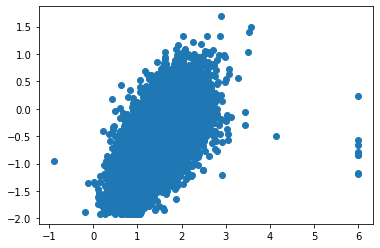

In [42]:
plt.scatter((sr_test.param_estimates[0,:,0]+)-sr_test.param_estimates[0,:,1],
            np.log10(np.mean(sd_test.layers[0],axis=1)))